In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from pathlib import Path

%matplotlib inline

## 1. Load Processed Artifacts from Phase 1

Let's load the edge-detected pieces from a test puzzle.

In [2]:
# Configuration
PUZZLE_TYPE = "puzzle_2x2"
IMAGE_ID = "0"
ARTIFACT_DIR = f"./processed_artifacts/{PUZZLE_TYPE}/image_{IMAGE_ID}"

# Load metadata
with open(f"{ARTIFACT_DIR}/metadata.json", 'r') as f:
    metadata = json.load(f)

grid_size = metadata['grid_size']
num_pieces = metadata['num_pieces']

print(f"Loaded puzzle: {PUZZLE_TYPE}, Image {IMAGE_ID}")
print(f"Grid size: {grid_size}x{grid_size}")
print(f"Number of pieces: {num_pieces}")

Loaded puzzle: puzzle_2x2, Image 0
Grid size: 2x2
Number of pieces: 4


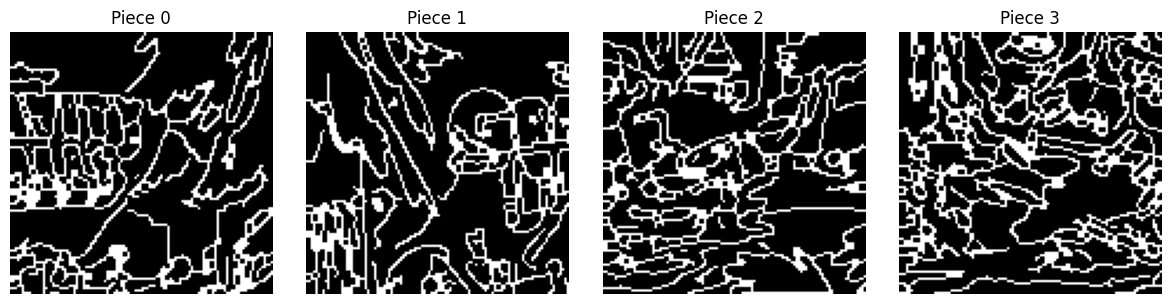

In [3]:
# Load all edge images
edge_images = []
for i in range(num_pieces):
    edge_path = f"{ARTIFACT_DIR}/edge_images/piece_{i:02d}_edges.png"
    edge_img = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)
    edge_images.append(edge_img)

# Display all edge images
fig, axes = plt.subplots(1, grid_size * grid_size, figsize=(12, 3))
for idx, (ax, edge_img) in enumerate(zip(axes.flatten(), edge_images)):
    ax.imshow(edge_img, cmap='gray')
    ax.set_title(f"Piece {idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Extract Edge Profiles

For each piece, we extract the edge profile from each of its 4 sides (top, right, bottom, left).
An edge profile is a 1D array representing the edge intensity along that side.

In [4]:
def extract_edge_profiles(edge_image):
    """
    Extract edge profiles from all 4 sides of a piece.
    
    Returns:
        dict with keys: 'top', 'right', 'bottom', 'left'
        Each value is a 1D numpy array
    """
    h, w = edge_image.shape
    
    profiles = {
        'top': edge_image[0, :],           # First row
        'bottom': edge_image[-1, :],       # Last row
        'left': edge_image[:, 0],          # First column
        'right': edge_image[:, -1]         # Last column
    }
    
    return profiles

# Extract profiles for all pieces
all_profiles = []
for idx, edge_img in enumerate(edge_images):
    profiles = extract_edge_profiles(edge_img)
    all_profiles.append(profiles)
    print(f"Piece {idx} - Profile shapes: Top={profiles['top'].shape}, Right={profiles['right'].shape}")

Piece 0 - Profile shapes: Top=(112,), Right=(112,)
Piece 1 - Profile shapes: Top=(112,), Right=(112,)
Piece 2 - Profile shapes: Top=(112,), Right=(112,)
Piece 3 - Profile shapes: Top=(112,), Right=(112,)


## 3. Visualize Edge Profiles

Let's visualize the edge profiles for the first piece.

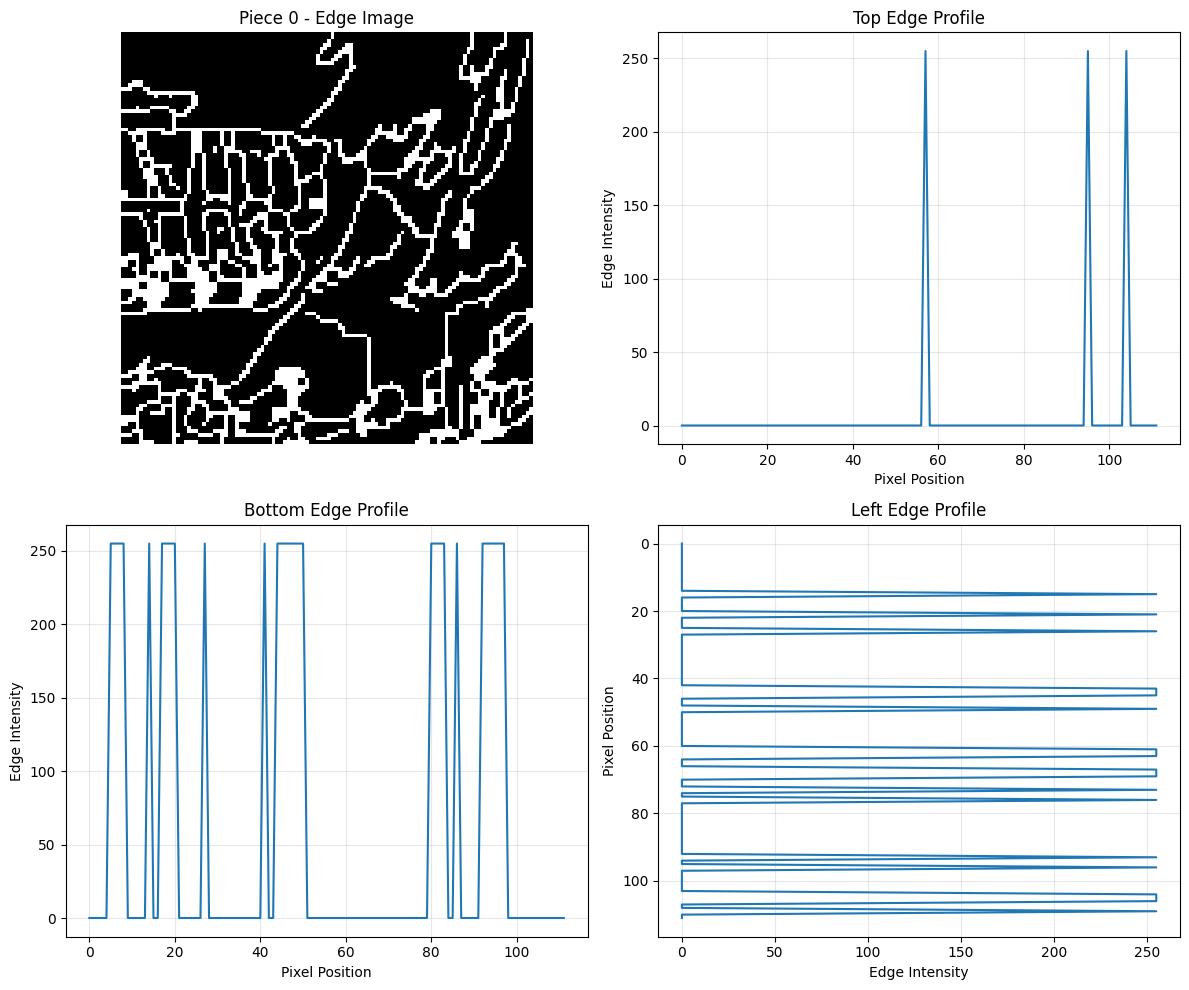

In [5]:
# Visualize profiles for piece 0
piece_idx = 0
profiles = all_profiles[piece_idx]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Show the piece
axes[0, 0].imshow(edge_images[piece_idx], cmap='gray')
axes[0, 0].set_title(f'Piece {piece_idx} - Edge Image')
axes[0, 0].axis('off')

# Plot profiles
axes[0, 1].plot(profiles['top'])
axes[0, 1].set_title('Top Edge Profile')
axes[0, 1].set_xlabel('Pixel Position')
axes[0, 1].set_ylabel('Edge Intensity')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(profiles['bottom'])
axes[1, 0].set_title('Bottom Edge Profile')
axes[1, 0].set_xlabel('Pixel Position')
axes[1, 0].set_ylabel('Edge Intensity')
axes[1, 0].grid(True, alpha=0.3)

# For left/right, plot vertically
axes[1, 1].plot(profiles['left'], range(len(profiles['left'])))
axes[1, 1].set_title('Left Edge Profile')
axes[1, 1].set_xlabel('Edge Intensity')
axes[1, 1].set_ylabel('Pixel Position')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Edge Similarity Metrics

Now let's implement different similarity metrics to compare edges:
1. **Sum of Squared Differences (SSD)** - Lower is better
2. **Normalized Cross-Correlation (NCC)** - Higher is better
3. **Correlation Coefficient** - Higher is better

In [6]:
def compare_edges_ssd(profile1, profile2):
    """
    Sum of Squared Differences - Lower score means better match.
    """
    # Ensure same length
    min_len = min(len(profile1), len(profile2))
    p1 = profile1[:min_len].astype(np.float32)
    p2 = profile2[:min_len].astype(np.float32)
    
    ssd = np.sum((p1 - p2) ** 2)
    return ssd

def compare_edges_ncc(profile1, profile2):
    """
    Normalized Cross-Correlation - Higher score means better match.
    Range: [-1, 1], where 1 is perfect match.
    """
    min_len = min(len(profile1), len(profile2))
    p1 = profile1[:min_len].astype(np.float32)
    p2 = profile2[:min_len].astype(np.float32)
    
    # Normalize
    p1_norm = (p1 - np.mean(p1)) / (np.std(p1) + 1e-6)
    p2_norm = (p2 - np.mean(p2)) / (np.std(p2) + 1e-6)
    
    ncc = np.mean(p1_norm * p2_norm)
    return ncc

def compare_edges_correlation(profile1, profile2):
    """
    Pearson Correlation Coefficient - Higher score means better match.
    Range: [-1, 1], where 1 is perfect positive correlation.
    """
    min_len = min(len(profile1), len(profile2))
    p1 = profile1[:min_len].astype(np.float32)
    p2 = profile2[:min_len].astype(np.float32)
    
    corr = np.corrcoef(p1, p2)[0, 1]
    return corr if not np.isnan(corr) else 0

print("Edge similarity functions ready!")

Edge similarity functions ready!


## 5. Compare All Edges

For a 2x2 puzzle, the correct matches should be:
- Piece 0 (top-left): right → Piece 1, bottom → Piece 2
- Piece 1 (top-right): left → Piece 0, bottom → Piece 3
- Piece 2 (bottom-left): top → Piece 0, right → Piece 3
- Piece 3 (bottom-right): top → Piece 1, left → Piece 2

In [7]:
def find_best_matches(all_profiles, method='ncc'):
    """
    Find best matching edges for all pieces.
    
    Args:
        all_profiles: List of profile dicts for each piece
        method: 'ssd', 'ncc', or 'correlation'
    
    Returns:
        Dictionary of matches for each piece and side
    """
    num_pieces = len(all_profiles)
    matches = {}
    
    # Complementary sides: top↔bottom, left↔right
    complements = {
        'top': 'bottom',
        'bottom': 'top',
        'left': 'right',
        'right': 'left'
    }
    
    for piece_idx in range(num_pieces):
        matches[piece_idx] = {}
        
        for side in ['top', 'right', 'bottom', 'left']:
            profile1 = all_profiles[piece_idx][side]
            complement_side = complements[side]
            
            best_score = -np.inf if method != 'ssd' else np.inf
            best_match = -1
            
            for other_idx in range(num_pieces):
                if other_idx == piece_idx:
                    continue
                
                profile2 = all_profiles[other_idx][complement_side]
                
                if method == 'ssd':
                    score = compare_edges_ssd(profile1, profile2)
                    if score < best_score:
                        best_score = score
                        best_match = other_idx
                elif method == 'ncc':
                    score = compare_edges_ncc(profile1, profile2)
                    if score > best_score:
                        best_score = score
                        best_match = other_idx
                elif method == 'correlation':
                    score = compare_edges_correlation(profile1, profile2)
                    if score > best_score:
                        best_score = score
                        best_match = other_idx
            
            matches[piece_idx][side] = {
                'match': best_match,
                'score': best_score
            }
    
    return matches

# Test all three methods
print("=== Finding Best Matches ===\n")

for method in ['ssd', 'ncc', 'correlation']:
    print(f"\n--- Method: {method.upper()} ---")
    matches = find_best_matches(all_profiles, method=method)
    
    for piece_idx in range(num_pieces):
        print(f"\nPiece {piece_idx}:")
        for side in ['top', 'right', 'bottom', 'left']:
            match_info = matches[piece_idx][side]
            print(f"  {side:6s} → Piece {match_info['match']} (score: {match_info['score']:.4f})")

=== Finding Best Matches ===


--- Method: SSD ---

Piece 0:
  top    → Piece 3 (score: 1430550.0000)
  right  → Piece 1 (score: 845325.0000)
  bottom → Piece 1 (score: 2015775.0000)
  left   → Piece 2 (score: 1755675.0000)

Piece 1:
  top    → Piece 3 (score: 1885725.0000)
  right  → Piece 3 (score: 2015775.0000)
  bottom → Piece 3 (score: 1690650.0000)
  left   → Piece 0 (score: 845325.0000)

Piece 2:
  top    → Piece 1 (score: 2210850.0000)
  right  → Piece 1 (score: 1495575.0000)
  bottom → Piece 0 (score: 3121200.0000)
  left   → Piece 0 (score: 1625625.0000)

Piece 3:
  top    → Piece 1 (score: 1690650.0000)
  right  → Piece 1 (score: 1950750.0000)
  bottom → Piece 0 (score: 1430550.0000)
  left   → Piece 0 (score: 1235475.0000)

--- Method: NCC ---

Piece 0:
  top    → Piece 3 (score: 0.0620)
  right  → Piece 1 (score: 0.1731)
  bottom → Piece 1 (score: 0.0735)
  left   → Piece 2 (score: 0.0951)

Piece 1:
  top    → Piece 0 (score: 0.0735)
  right  → Piece 0 (score: 0.0836)
  bo

## 6. Visualize Matching Results

Let's visualize the best matches by overlaying the edge profiles.

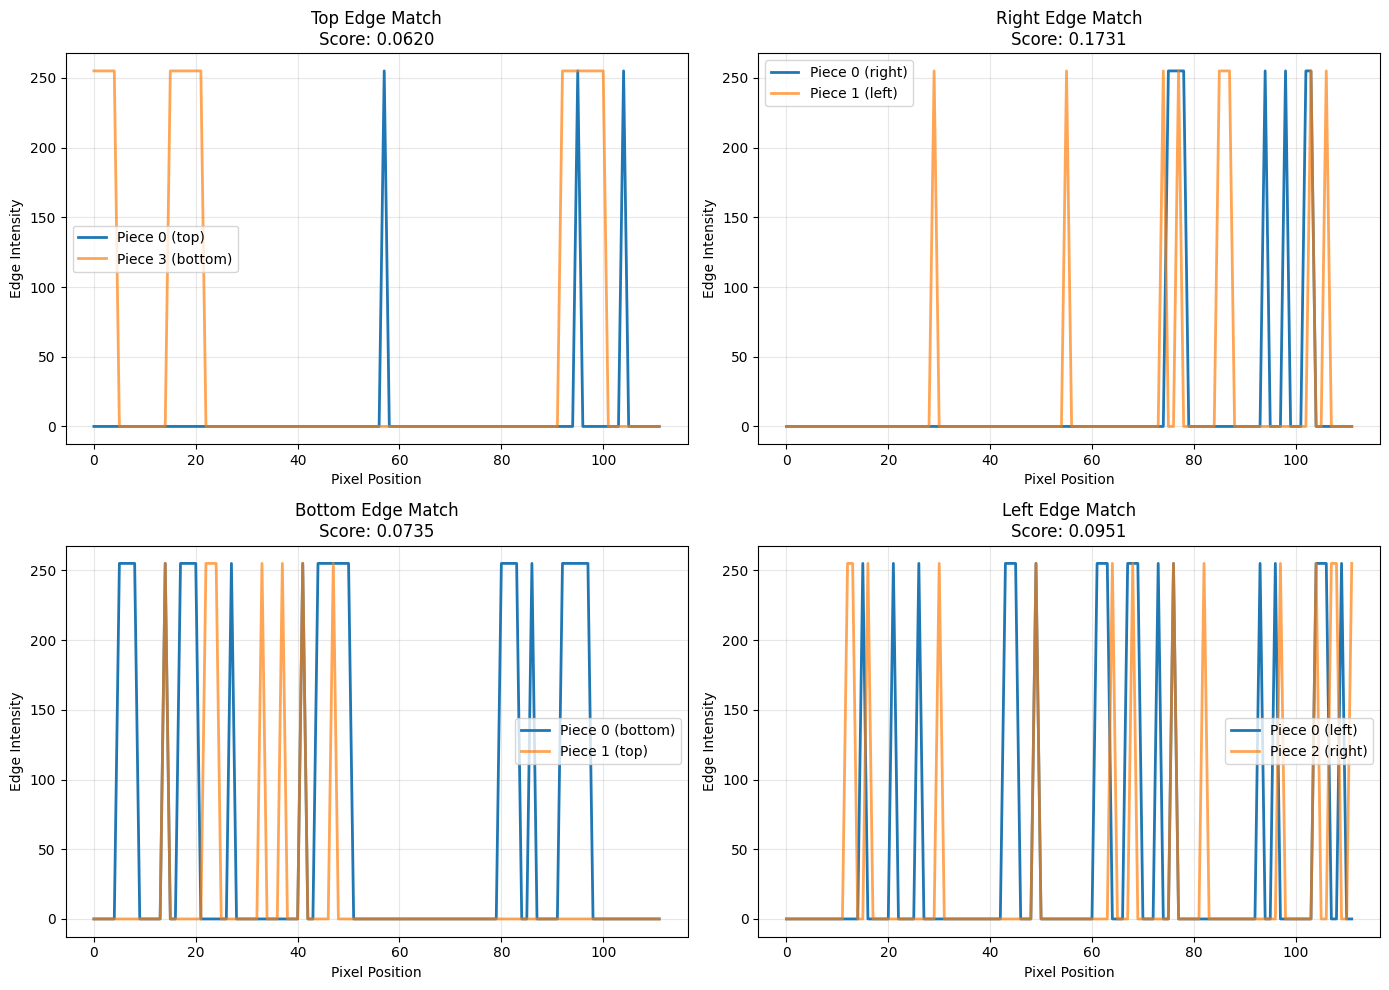

In [8]:
# Visualize matches for a specific piece using NCC method
piece_idx = 0
matches = find_best_matches(all_profiles, method='ncc')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

sides = ['top', 'right', 'bottom', 'left']
complements = {'top': 'bottom', 'bottom': 'top', 'left': 'right', 'right': 'left'}

for idx, side in enumerate(sides):
    ax = axes[idx]
    
    profile1 = all_profiles[piece_idx][side]
    match_idx = matches[piece_idx][side]['match']
    match_score = matches[piece_idx][side]['score']
    complement_side = complements[side]
    profile2 = all_profiles[match_idx][complement_side]
    
    # Plot both profiles
    ax.plot(profile1, label=f'Piece {piece_idx} ({side})', linewidth=2)
    ax.plot(profile2, label=f'Piece {match_idx} ({complement_side})', linewidth=2, alpha=0.7)
    
    ax.set_title(f'{side.capitalize()} Edge Match\nScore: {match_score:.4f}')
    ax.set_xlabel('Pixel Position')
    ax.set_ylabel('Edge Intensity')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Next Steps

This notebook demonstrates the core concept of edge matching. Key findings:
- Edge profiles can be extracted from any side of a piece
- Multiple similarity metrics can be used (SSD, NCC, Correlation)
- We can identify potential neighbors by comparing complementary edges

**Next:** In `piece_assembly_visualizer.ipynb`, we'll use these matches to actually assemble the puzzle pieces into the correct configuration.